# HAB Capstone Modeling

In [380]:
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split

import xgboost as xgb

## Import data and initialize score dictionaries

In [2]:
X_train_df = pd.read_csv('../data/processed/scaled_Xtrain.csv', index_col=0)
X_test_df = pd.read_csv('../data/processed/scaled_Xtest.csv', index_col=0)
y_train_df = pd.read_csv('../data/processed/scaled_ytrain.csv', index_col=0)
y_test_df = pd.read_csv('../data/processed/scaled_ytest.csv', index_col=0)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.flatten()
y_test = y_test_df.values.flatten()

In [185]:
training_scores = dict()
testing_scores = dict()

# 1. Regression Modeling

Our goal is to model future microcystin concentrations using past values, that is, to only use features that could be obtained prior to the predicted day. However, we will begin modeling using the full feature set to get an idea of how the different models behave and the relative predictive power of the features. Then we will move on to predictions using restricted feature sets. 

## 1.a. All Features, Scaled Data

### 1.a.i. OLS Regression

We will start with just a simple linear regression using ordinary least squares.

In [4]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_train, y_train)

0.6369813964501366

We can use sklearn's built-in metric functions to get a better idea of the model's performance.

In [132]:
def model_train_scores(model, X_train=X_train, y_train=y_train):
    
    """Returns a dictionary of MSE, MAE, and R2 values for a linear regression model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    train_scores = dict()
    for metric_name, func in zip(['MSE', 'MAE', 'R2'],[mean_squared_error, mean_absolute_error, r2_score]):
        train_scores[metric_name] = func(y_train, y_pred)
        
    return train_scores

def model_test_scores(model, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train):
    
    """Returns a dictionary of MSE, MAE, and R2 values for a linear regression model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_scores = dict()
    for metric_name, func in zip(['MSE', 'MAE', 'R2'],[mean_squared_error, mean_absolute_error, r2_score]):
        test_scores[metric_name] = func(y_test, y_pred)
        
    return test_scores

In [187]:
training_scores['OLS - Full Features'] = model_train_scores(ols)
training_scores['OLS - Full Features']

{'MSE': 0.3631272127214374,
 'MAE': 0.4757166885947869,
 'R2': 0.6368727872785627}

In [231]:
def model_train_plot(model, X_train=X_train, y_train=y_train, name='Model', value='Value'):
    y_pred = model.predict(X_train)
    x = np.linspace(min(y_train), max(y_train), 50)
    y = x
    plt.plot(x, y, '-r', label='perfect prediction')
    plt.scatter(y_train, y_pred, alpha=0.5)
    plt.legend()
    plt.xlabel('True ' + value)
    plt.ylabel('Predicted ' + value)
    plt.title(name + ' Results - Training Data')
    plt.show()
    
def model_test_plot(model, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train, name='Model', value='Value'):
    y_pred = model.predict(X_test)
    x = np.linspace(min(y_test), max(y_test), 50)
    y = x
    plt.plot(x, y, '-r', label='perfect prediction')
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.legend()
    plt.xlabel('True ' + value)
    plt.ylabel('Predicted ' + value)
    plt.title(name + ' Results - Testing Data')
    plt.show()

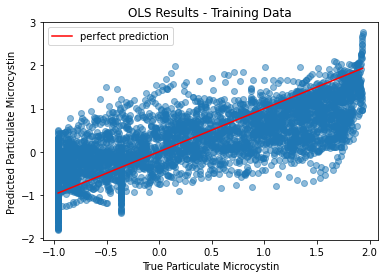

In [217]:
model_train_plot(ols, name='OLS', value='Particulate Microcystin')

Overall OLS is doing a pretty poor job of predicting the particulate microcystin concentration even on the training set, with errors on the order of one to two standard deviations. 

In [188]:
testing_scores['OLS - Full Features'] = model_test_scores(ols)
testing_scores['OLS - Full Features'] 

{'MSE': 0.3799613043042101,
 'MAE': 0.48377372757355125,
 'R2': 0.6112952465247499}

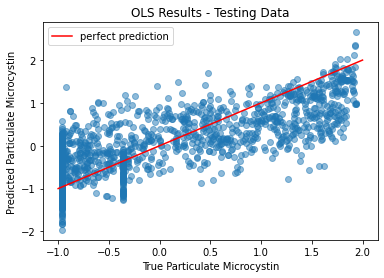

In [139]:
model_test_plot(ols, name='OLS', value='Particulate Microcystin')

The test scores an plots are slightly worse, as expected.

### 1.a.ii. Ridge Regression

We will start with using a grid search to determine the optimal alpha value.

In [14]:
ridge = Ridge()
alpha_ridge = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1, 5, 10, 20]
params = {'alpha': alpha_ridge}
ridgecv = GridSearchCV(ridge, params, cv=5)
ridgecv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1, 5, 10,
                                   20]})

In [15]:
pd.DataFrame(ridgecv.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.010890,0.001162,0.001535,0.000306,1,{'alpha': 1},0.629556,0.625686,0.653990,0.600387,0.631320,0.628188,0.017068,1
4,0.011034,0.001285,0.001559,0.000335,0.01,{'alpha': 0.01},0.629314,0.625885,0.654710,0.601297,0.629699,0.628181,0.016943,2
3,0.010959,0.001307,0.002365,0.001091,0.0001,{'alpha': 0.0001},0.629287,0.625891,0.654726,0.601329,0.629593,0.628165,0.016936,3
2,0.010068,0.001696,0.002443,0.001686,1e-06,{'alpha': 1e-06},0.629286,0.625891,0.654726,0.601330,0.629592,0.628165,0.016936,4
1,0.016485,0.007148,0.001761,0.000431,1e-08,{'alpha': 1e-08},0.629286,0.625891,0.654726,0.601330,0.629592,0.628165,0.016936,5
0,0.038308,0.035268,0.003368,0.003698,1e-10,{'alpha': 1e-10},0.629286,0.625891,0.654726,0.601330,0.629592,0.628165,0.016936,6
6,0.011327,0.001636,0.001504,0.000243,5,{'alpha': 5},0.629220,0.625888,0.653168,0.600093,0.631142,0.627902,0.016900,7
7,0.012335,0.001926,0.001423,0.000124,10,{'alpha': 10},0.628743,0.626052,0.652454,0.600043,0.630564,0.627571,0.016671,8
8,0.010319,0.001798,0.001562,0.000181,20,{'alpha': 20},0.627997,0.626284,0.651293,0.600068,0.629593,0.627047,0.016271,9


The best value is alpha=1 with alpha=0.01 as the second best. There is almost no difference in average score with these alpha values, so we can take alpha=1 to be the best value without searching further.

In [189]:
ridge_best = Ridge(alpha=1)

training_scores['Ridge - Full Features'] = model_train_scores(ridge_best)
training_scores['Ridge - Full Features']

{'MSE': 0.3631703715525051,
 'MAE': 0.4747499666483122,
 'R2': 0.6368296284474949}

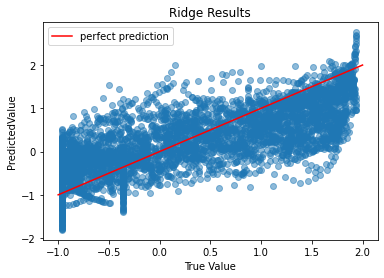

In [86]:
model_train_plot(ridge_best, name='Ridge')

In [191]:
testing_scores['Ridge - Full Features'] = model_test_scores(ridge_best)
testing_scores['Ridge - Full Features']

{'MSE': 0.3798287265263438, 'MAE': 0.482749623745037, 'R2': 0.6114308751055502}

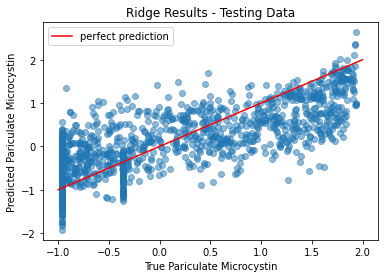

In [141]:
model_test_plot(ridge_best, name='Ridge', value='Pariculate Microcystin')

Ridge regression performs very similarly to OLS. We can look at feature coefficients to get an idea of the importance of various features.

In [33]:
features = X_train_df.columns

In [34]:
ridge_coef = pd.DataFrame({'features': features,
                           'ridge_coef': ridge_best.coef_.flatten()})
ridge_coef['abs_ridge_coef'] = ridge_coef.ridge_coef.apply(np.abs)

In [35]:
ridge_coef = ridge_coef.sort_values('abs_ridge_coef', ascending=False)

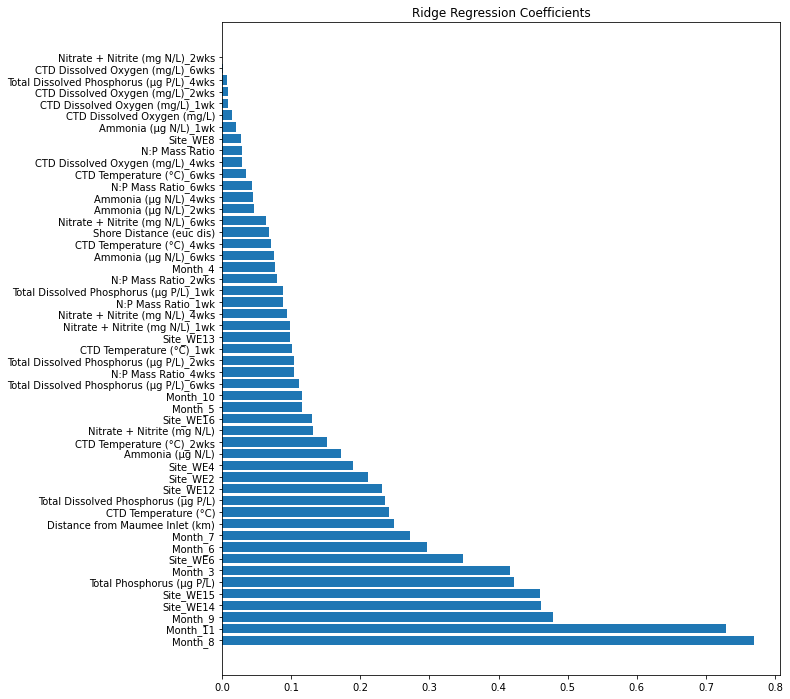

In [36]:
plt.figure(figsize=(10,12))
plt.barh(y=ridge_coef['features'], 
         width=ridge_coef['abs_ridge_coef'])
plt.title('Ridge Regression Coefficients')
plt.show()

Time of year, site identity, and temperature seem to be the most important factors to the model.

### 1.a.iii. Lasso

Lasso may give us a better idea of which features are important by heavily penalizing the inclusion of features that don't really increase the model's predictive power.

In [192]:
lasso = LassoCV()

training_scores['Lasso - Full Features'] = model_train_scores(lasso)
training_scores['Lasso - Full Features']

{'MSE': 0.364070966486341, 'MAE': 0.475446074825686, 'R2': 0.6359290335136589}

In [40]:
lasso.alpha_

0.0005191533235328925

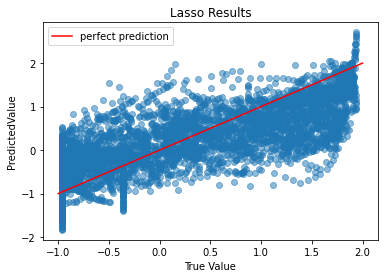

In [87]:
model_train_plot(lasso, name='Lasso')

In [193]:
testing_scores['Lasso - Full Features'] = model_test_scores(lasso)
testing_scores['Lasso - Full Features']

{'MSE': 0.38031176699995245,
 'MAE': 0.48315349840183675,
 'R2': 0.6109367191847086}

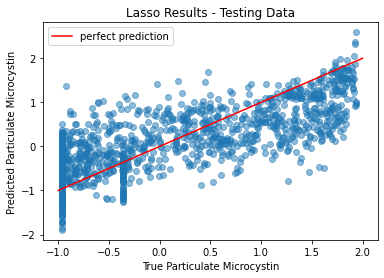

In [143]:
model_test_plot(lasso, name='Lasso', value='Particulate Microcystin')

Again this is very similar to the Ridge and OLS results.

In [43]:
lasso_coef = pd.DataFrame({'features': features,
                           'lasso_coef': lasso.coef_})
lasso_coef['abs_lasso_coef'] = lasso_coef.lasso_coef.apply(np.abs)
lasso_coef.sort_values('abs_lasso_coef', ascending=False).head()

,features,lasso_coef,abs_lasso_coef
14,Month_8,0.743764,0.743764
15,Month_9,0.453676,0.453676
20,Total Phosphorus (µg P/L),0.416166,0.416166
17,Month_11,-0.391396,0.391396
12,Month_6,-0.297653,0.297653


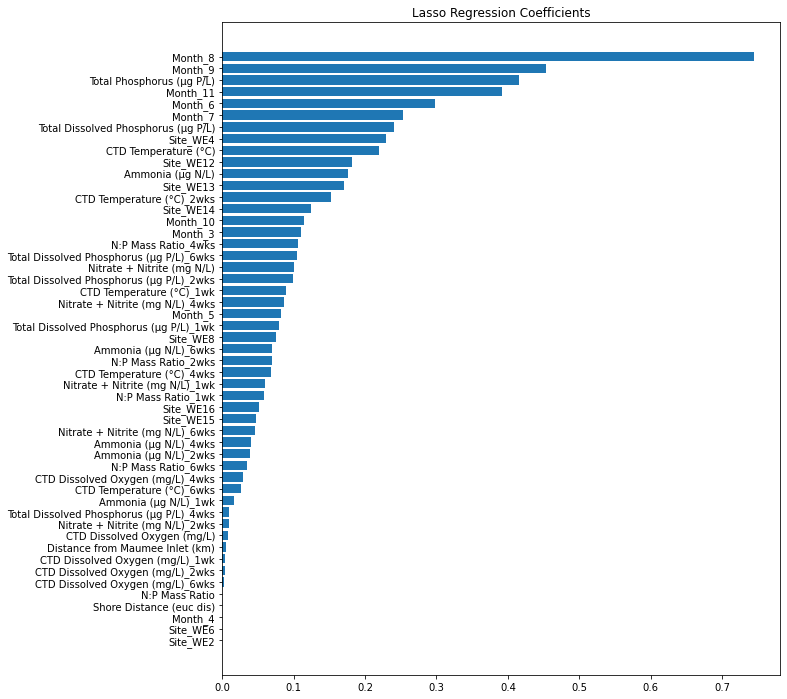

In [44]:
plt.figure(figsize=(10,12))
plt.barh(y=lasso_coef.sort_values('abs_lasso_coef')['features'], 
         width=lasso_coef.sort_values('abs_lasso_coef')['abs_lasso_coef'])
plt.title('Lasso Regression Coefficients')
plt.show()

Again time of year and location are the most influential factors, with the largest coefficients.

### 1.a.iv. Random Forest

Random Forest has many parameters that can be tuned, including maximum tree depth, maximum features included in each tree, minimum samples per leaf, minimum samples per split, and number of trees. We will optimize these parameters using several methods and compare. First we will use Bayesion optimization.

In [45]:
#define evaluation function for bayesion optimization hyperparameter search
def rf_eval(max_depth, min_samples_leaf, min_samples_split, n_estimators):
    params = {
        'max_depth': [int(max_depth)],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [int(min_samples_leaf)],
        'min_samples_split': [int(min_samples_split)],
        'n_estimators': [int(n_estimators)]
    }
    rf = RandomForestRegressor()
    cv_result = GridSearchCV(rf, params, cv=3)
    cv_result.fit(X_train, y_train)

    return cv_result.best_score_

In [47]:
#perform bayesion optimization search
rfBO = BayesianOptimization(rf_eval, {'max_depth': (2,100), 'min_samples_leaf': (1,5), 
                                      'min_samples_split': (2,10), 'n_estimators': (100, 1000)})
rfBO.maximize(n_iter=10, init_points=4)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9192   |  54.64    |  4.63     |  6.617    |  661.4    |
|  2        |  0.9194   |  34.96    |  4.044    |  7.52     |  786.2    |
|  3        |  0.9238   |  83.91    |  3.594    |  7.619    |  239.2    |
|  4        |  0.9408   |  41.12    |  1.712    |  4.0      |  380.1    |
|  5        |  0.9194   |  41.55    |  4.189    |  2.954    |  379.2    |
|  6        |  0.9246   |  65.16    |  3.733    |  7.927    |  359.8    |
|  7        |  0.9334   |  71.04    |  2.524    |  3.521    |  725.7    |
|  8        |  0.9242   |  14.97    |  3.009    |  5.218    |  439.9    |
|  9        |  0.9272   |  27.49    |  3.676    |  5.721    |  836.9    |
|  10       |  0.9263   |  29.5     |  3.562    |  4.949    |  514.3    |
|  11       |  0.9304   |  56.63    |  2.871    |  6.284    |  953.0    |
|  12       |  0.93     |  36.28    | 

In [48]:
#perform randomized hyperparameter search for comparison
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf = RandomForestRegressor()
rfcv = RandomizedSearchCV(rf, params, cv=3, verbose=10, n_jobs=-1)

rfcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 16.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 18.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=10)

In [49]:
#examine randomized search outputs
pd.DataFrame(rfcv.cv_results_).sort_values('rank_test_score').T

,9,7,4,5,3,6,2,0,1,8
mean_fit_time,53.7707,342.592,87.7676,216.615,37.5124,35.4684,69.3236,27.0656,294.016,211.98
std_fit_time,1.89923,7.58061,1.31603,12.6732,1.39015,2.85551,7.07263,0.195667,1.49818,17.9318
mean_score_time,2.96953,2.67676,2.71232,1.19971,0.219829,1.01847,0.413843,1.15404,1.58463,0.705132
std_score_time,0.348957,0.519596,0.318696,0.2444,0.131097,0.233222,0.125422,0.0792217,0.199032,0.0850549
param_n_estimators,1000,1000,1000,500,100,500,200,500,1000,1000
param_min_samples_split,2,2,4,4,10,10,10,4,10,10
param_min_samples_leaf,1,1,1,1,1,1,4,4,1,4
param_max_features,sqrt,auto,sqrt,auto,auto,sqrt,auto,sqrt,auto,auto
param_max_depth,None,None,100,None,None,50,None,50,10,10
params,"{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 500, 'min_samples_split': 4, ...","{'n_estimators': 100, 'min_samples_split': 10,...","{'n_estimators': 500, 'min_samples_split': 10,...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 500, 'min_samples_split': 4, ...","{'n_estimators': 1000, 'min_samples_split': 10...","{'n_estimators': 1000, 'min_samples_split': 10..."


It seems that the best parameters were found through the random search.

In [194]:
rf_best = RandomForestRegressor(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, 
                                  max_features='sqrt', max_depth=None)

training_scores['Random Forest - Full Features'] = model_train_scores(rf_best)
training_scores['Random Forest - Full Features']

{'MSE': 0.004766007951959668,
 'MAE': 0.04375624504823381,
 'R2': 0.9952339920480403}

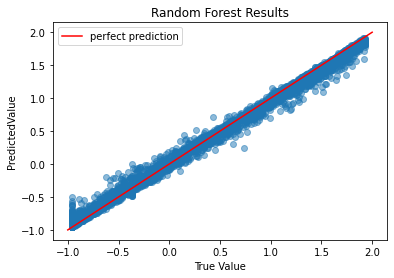

In [88]:
model_train_plot(rf_best, name="Random Forest")

In [195]:
testing_scores['Random Forest - Full Features'] = model_test_scores(rf_best)
testing_scores['Random Forest - Full Features']

{'MSE': 0.03954112669799644,
 'MAE': 0.12382246227277542,
 'R2': 0.9595489758268312}

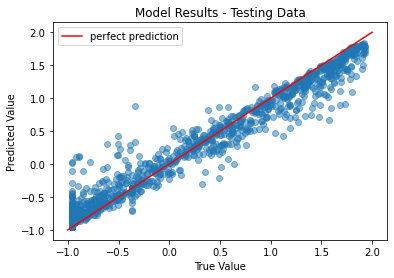

In [146]:
model_test_plot(rf_best)

The random forest ensemble performs much better than linear methods. We can examine the feature importances using the shap package. 

In [77]:
data = shap.sample(X_train, 100)
rf_explainer = shap.Explainer(rf_best.predict, data)

In [59]:
shap_values = rf_explainer(data)

Permutation explainer: 101it [47:40, 28.61s/it]                          


In [61]:
shap_values.feature_names = features

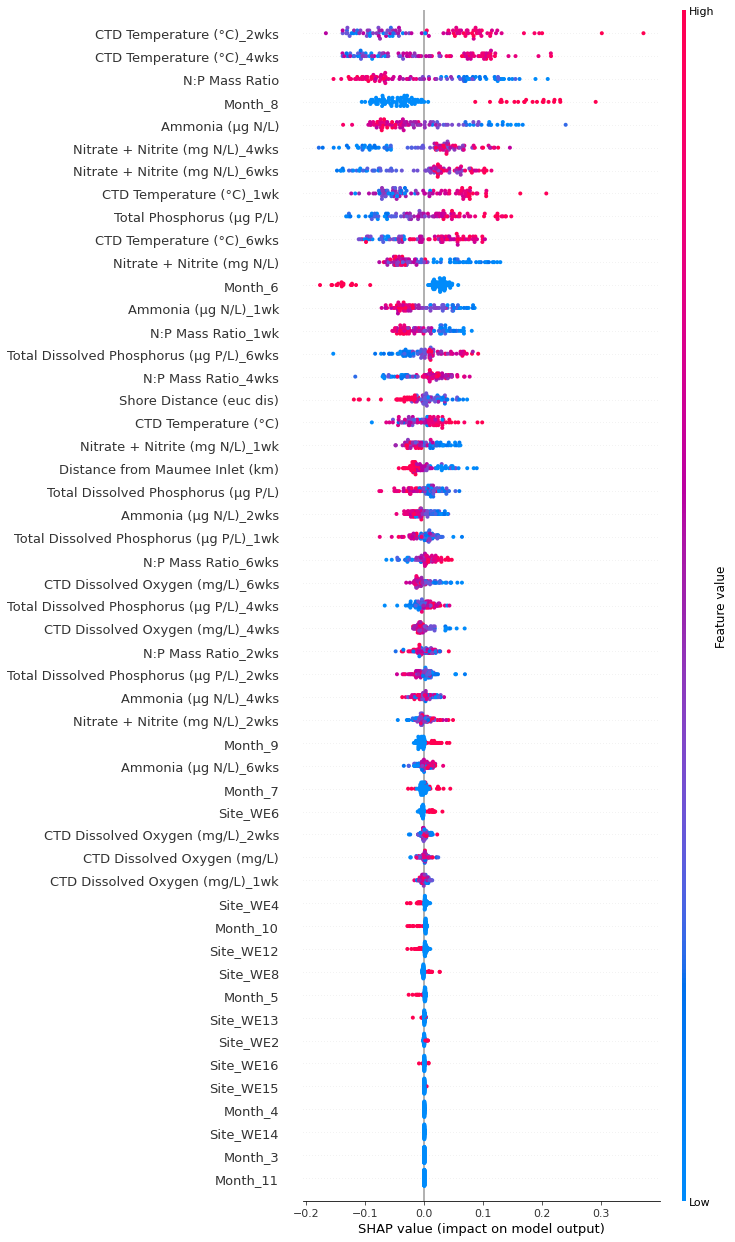

In [62]:
shap.plots.beeswarm(shap_values)

### 1.a.v. Gradient Boosting with XGBoost

Gradient boosted trees are another method for improving performance. Let's just try a basic XGBRegressor to get a feel for its performance.

In [129]:
#Try out a basic XGBRegressor
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [197]:
model_train_scores(xgbr)

{'MSE': 0.004172686097460348,
 'MAE': 0.044538939451373015,
 'R2': 0.9958273139025396}

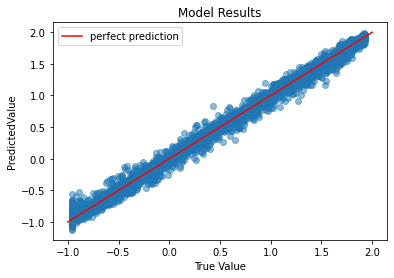

In [131]:
model_train_plot(xgbr)

The default XGBRegressor appears to perform fairly well, slightly better than the regular random forest on the training data, but the model is likely overfitting since it was not evaluated through cross-validation on the training set. We will try to prevent overfitting by changing several parameters:
<ol><li>max_depth - controls the number of splits for each tree.</li>
    <li>min_child_weight - required weight for each split, large values make splits more conservative.</li>
    <li>gamma - minimum loss reduction required to further partition a node.</li></ol>
We will also try changing the number of estimators, which is the number of boosting rounds, and the learning rate.

In [153]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             max_delta_step=0, max_depth=6, monotone_constraints='()',
             num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
xgbcv = RandomizedSearchCV(xgbr, params, cv=3, verbose=10, n_jobs=-1)

xgbcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   50.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   50.6s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=None, max_delta_step=0,
                                          max_depth=6, min_child_weight=None,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=None,
                                          nu...
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
   

In [154]:
xgbcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=100,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [155]:
pd.DataFrame(xgbcv.cv_results_).sort_values('rank_test_score').T

,7,3,2,6,8,5,1,4,9,0
mean_fit_time,3.84842,6.7833,11.0444,5.4432,0.682929,6.79113,3.50662,17.6829,0.53564,1.53262
std_fit_time,0.17,0.551115,0.11577,0.0562872,0.0100773,0.872943,0.488462,0.0961954,0.0314663,0.0186351
mean_score_time,0.0181056,0.0284126,0.0212111,0.0208209,0.00708596,0.0444624,0.0236603,0.115075,0.00643992,0.00944058
std_score_time,0.00262077,0.0102224,0.00296888,0.00426233,0.000694334,0.0204635,0.00897048,0.0477461,0.00100974,0.000390991
param_n_estimators,20,100,50,100,10,100,50,100,10,10
param_min_child_weight,0.5,1,3,1,0.5,0.5,3,1,3,1
param_max_depth,100,10,50,None,None,None,None,100,None,50
param_learning_rate,0.3,0.1,0.2,0.1,0.2,0.01,0.01,0.001,0.01,0.001
param_gamma,0,0.5,0.25,1,0.25,0,0,0,0,0
param_colsample_bytree,0.8,0.5,0.9,0.7,0.9,0.7,0.8,0.8,0.8,0.9


In [151]:
#define evaluation function for bayesion optimization hyperparameter search
def xgbr_eval(max_depth, learning_rate, min_child_weight, gamma, colsample_bytree, n_estimators):
    params = {
        'max_depth': [int(max_depth)],
        'learning_rate': [learning_rate],
        'min_child_weight': [min_child_weight],
        'gamma': [gamma],
        'n_estimators': [int(n_estimators)],
        'colsample_bytree': [colsample_bytree]
    }
    xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             max_delta_step=0, max_depth=6, monotone_constraints='()',
             num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
    cv_result = GridSearchCV(xgbr, params, cv=3)
    cv_result.fit(X_train, y_train)

    return cv_result.best_score_

In [152]:
#perform bayesion optimization search
xgbBO = BayesianOptimization(xgbr_eval, {'max_depth': (2,100), 'learning_rate': (0.001, 0.5), 
                                         'min_child_weight': (0,5), 'gamma': (0, 1), 'colsample_bytree': (0.2, 1),
                                         'n_estimators': (10, 100)})
xgbBO.maximize(n_iter=10, init_points=4)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        |  0.8682   |  0.4018   |  0.5321   |  0.1031   |  58.52    |  2.833    |  16.41    |
|  2        |  0.9334   |  0.8276   |  0.3511   |  0.05333  |  72.74    |  4.691    |  74.58    |
|  3        |  0.8801   |  0.7758   |  0.6493   |  0.1488   |  4.687    |  2.802    |  86.46    |
|  4        |  0.9188   |  0.5262   |  0.8086   |  0.05807  |  19.55    |  0.04973  |  53.16    |
|  5        |  0.8991   |  0.9897   |  0.7134   |  0.494    |  71.81    |  4.039    |  75.07    |
|  6        |  0.6273   |  0.2892   |  0.08515  |  0.01838  |  4.705    |  1.466    |  74.75    |
|  7        | -0.1178   |  0.2      |  0.0      |  0.001    |  78.45    |  5.0      |  71.64    |
|  8        |  0.9157   |  0.5009   |  0.8657   |  0.1895   |  20.95    |  1.319    |  57.68    |
|  9        |  0.908

The best performance seems to be the best estimator identified through randomized search.

In [198]:
xgb_best = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=100,
             min_child_weight=0.5, monotone_constraints='()',
             n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

training_scores['XGBoost - Full Features'] = model_train_scores(xgb_best)
training_scores['XGBoost - Full Features']

{'MSE': 2.2537700590310315e-05,
 'MAE': 0.002348492666897913,
 'R2': 0.9999774622994096}

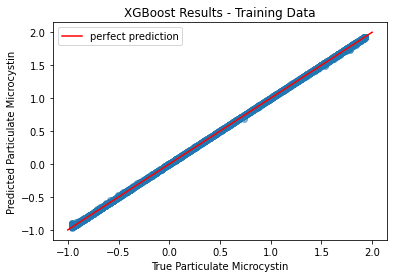

In [157]:
model_train_plot(xgb_best, name="XGBoost", value="Particulate Microcystin")

In [199]:
testing_scores['XGBoost - Full Features'] = model_test_scores(xgb_best)
testing_scores['XGBoost - Full Features']

{'MSE': 0.04090758391261189,
 'MAE': 0.10551116710816776,
 'R2': 0.9581510744912881}

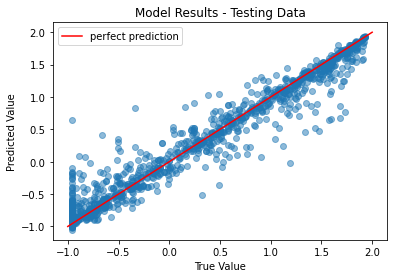

In [159]:
model_test_plot(xgb_best)

The XGBoost performance is slightly better than the Random Forest performance according to mean average error but overall roughly equivalent.

## 1.b. Regression Modeling with Scaled Past Features

Our goal is to be able to forecast microcystin concentrations based on past nutrient concentrations and environmental data. Therefore we will try to train models using only features that are obtainable two weeks prior to the desired prediction date. Moreover, we will remove the site labels to see if we can make reasonable predictions based only on site distance from shore and from the Maumee River inlet.

In [64]:
X_train_df.columns

Index(['Site_WE12', 'Site_WE13', 'Site_WE14', 'Site_WE15', 'Site_WE16',
       'Site_WE2', 'Site_WE4', 'Site_WE6', 'Site_WE8', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
       'Total Phosphorus (µg P/L)', 'Total Dissolved Phosphorus (µg P/L)',
       'Ammonia (µg N/L)', 'Nitrate + Nitrite (mg N/L)', 'N:P Mass Ratio',
       'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
       'CTD Temperature (°C)_1wk', 'CTD Temperature (°C)_2wks',
       'CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
       'CTD Dissolved Oxygen (mg/L)_1wk', 'CTD Dissolved Oxygen (mg/L)_2wks',
       'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
       'Total Dissolved Phosphorus (µg P/L)_1wk',
       'Total Dissolved Phosphorus (µg P/L)_2wks',
       'Total Dissolved Phosphorus (µg P/L)_4wks',
       'Total Dissolved Phosphorus (µg P/L)_6

In [163]:
X_past_df = X_train_df[['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11',
         'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
         'CTD Temperature (°C)_2wks', 'CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
         'CTD Dissolved Oxygen (mg/L)_2wks','CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
         'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks', 
         'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks', 'Ammonia (µg N/L)_6wks', 
         'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
         'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']]
X_past = X_past_df.values

X_past_test_df = X_test_df[['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11',
         'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
         'CTD Temperature (°C)_2wks', 'CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
         'CTD Dissolved Oxygen (mg/L)_2wks','CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
         'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks', 
         'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks', 'Ammonia (µg N/L)_6wks', 
         'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
         'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']]
X_past_test = X_past_test_df.values

### 1.b.i. Random Forest

Given the poor performance of linear models we will restrict our modeling of past features to decision trees. We will start with Random Forest, again tuning the parameters.

In [68]:
#perform randomized hyperparameter search 
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf_past = RandomForestRegressor()
rf_past_cv = RandomizedSearchCV(rf, params, cv=3, verbose=10, n_jobs=-1)

rf_past_cv.fit(X_past, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  8.9min remaining:   59.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=10)

In [69]:
#examine randomized search outputs
pd.DataFrame(rf_past_cv.cv_results_).sort_values('rank_test_score').T

,6,5,0,7,1,8,3,2,4,9
mean_fit_time,24.2444,20.2331,29.025,16.3667,247.27,141.805,98.237,25.9312,40.7878,56.4128
std_fit_time,0.868286,0.453787,0.143228,0.905712,1.54894,0.967959,11.5322,0.939724,0.314551,11.1629
mean_score_time,1.08785,0.144215,0.240357,0.109919,2.88059,0.961398,0.76651,0.28132,1.98509,0.418155
std_score_time,0.294065,0.0124172,0.0423036,0.0109787,0.959164,0.178504,0.12703,0.0312144,0.636143,0.0665034
param_n_estimators,500,100,100,100,1000,1000,500,100,1000,500
param_min_samples_split,2,2,4,10,4,4,2,4,10,10
param_min_samples_leaf,1,1,1,1,4,4,1,1,4,1
param_max_features,sqrt,auto,auto,auto,auto,auto,auto,auto,sqrt,auto
param_max_depth,None,None,50,100,None,50,10,10,None,10
params,"{'n_estimators': 500, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 100, 'min_samples_split': 10,...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 500, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 1000, 'min_samples_split': 10...","{'n_estimators': 500, 'min_samples_split': 10,..."


In [200]:
rf_past_best = RandomForestRegressor(n_estimators=500, min_samples_split=2, 
                                     min_samples_leaf=1, max_features='sqrt')
training_scores['Random Forest - Past Features'] = model_train_scores(rf_past_best, X_train=X_past)
training_scores['Random Forest - Past Features']

{'MSE': 0.0055741356826569215,
 'MAE': 0.04628681299454652,
 'R2': 0.994425864317343}

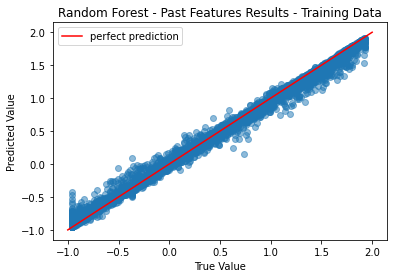

In [162]:
model_train_plot(rf_past_best, X_train=X_past, name="Random Forest - Past Features")

In [201]:
testing_scores['Random Forest - Past Features'] = model_test_scores(rf_past_best, X_test=X_past_test, X_train=X_past)
testing_scores['Random Forest - Past Features']

{'MSE': 0.04520497930432078,
 'MAE': 0.13086338427870306,
 'R2': 0.9537547899291567}

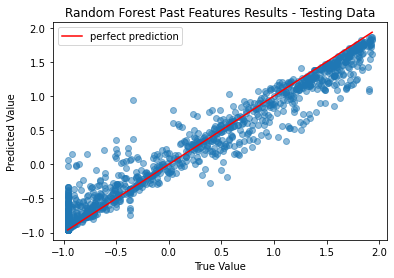

In [290]:
model_test_plot(rf_past_best, X_test=X_past_test, name='Random Forest Past Features')

The Random Forest model using past features seems to have a roughly equibalent performance compared to the full feature set, with a mean average error of 0.13 compared to 0.12. Since we are predicting log-transformed microcystin values we would need to transform the data back to its original units to get a better idea of the meaning of these errors. Both models tend to underestimate high microcystin values and overestimate low microcystin values. Let's transform the data back into the original µg/L units to get a better idea of how the model performs for different magnitudes of particulate microcystin concentrations.

In [277]:
logY = pickle.load(open('../models/logY.pickle', 'rb'))

y_pred_past = rf_past_best.predict(X_past_test).reshape(-1,1)
y_pred_past_ug = logY.inverse_transform(y_pred_past)
y_test_ug = logY.inverse_transform(y_test.reshape(-1,1))

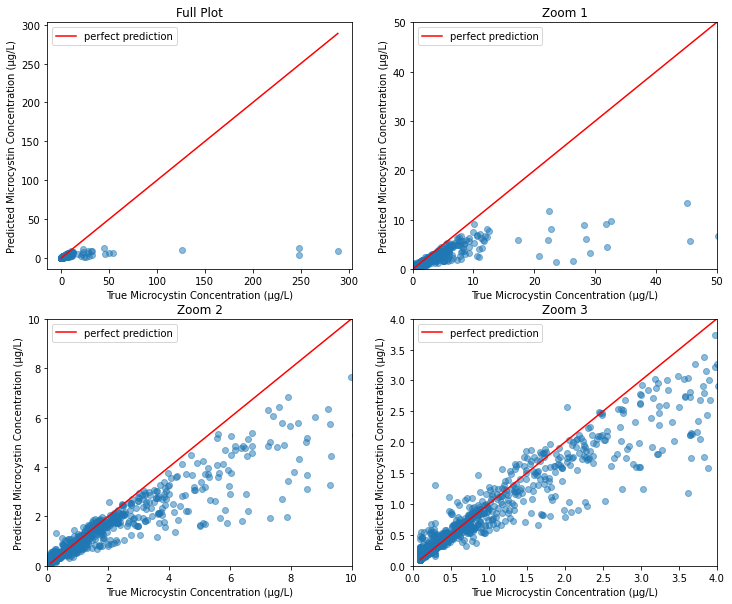

In [302]:
x = np.linspace(min(y_us_test), max(y_us_test), 50)
y = x
fig, ax = plt.subplots(2,2, figsize=(12,10))
for i in range(2):
    for j in range(2):
        ax[i, j].plot(x, y, '-r', label='perfect prediction')
        ax[i, j].scatter(y_test_ug, y_pred_past_ug, alpha=0.5)
        ax[i,j].legend()
        ax[i, j].set_xlabel('True Microcystin Concentration (µg/L)')
        ax[i, j].set_ylabel('Predicted Microcystin Concentration (µg/L)')
        #ax[i, j].set_title('Random Forest Unscaled Past Features Results - Testing Data')
        
ax[0,0].set_title('Full Plot')
        
ax[0,1].set_xlim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,1].set_title('Zoom 1')

ax[1,0].set_xlim(0,10)
ax[1,0].set_ylim(0,10)
ax[1,0].set_title('Zoom 2')

ax[1,1].set_xlim(0,4)
ax[1,1].set_ylim(0,4)
ax[1,1].set_title('Zoom 3')

plt.show()

In [303]:
mean_absolute_error(y_test_ug, y_pred_past_ug)

1.238184037960061

In [340]:
#example of difference in scaled error versus difference in unscaled error for small versus large target values
print('Two examples where scaled absolute error = 0.5: \n')
print('If the scaled target value is -0.5 then the unscaled error is:')
print((logY.inverse_transform([[0]]) - logY.inverse_transform([[-0.5]]))[0,0], 'µg/L', '\n')
print('If the scaled target value is 1.4 then the unscaled error is:')
print((logY.inverse_transform([[1.9]]) - logY.inverse_transform([[1.4]]))[0,0], 'µg/L')

Two examples where scaled absolute error = 0.5: 

If the scaled target value is -0.5 then the unscaled error is:
0.2143856550614751 µg/L 

If the scaled target value is 1.4 then the unscaled error is:
20.140933110140033 µg/L


The mean absolute error is 1.2 µg/L, which is relatively low. However, clearly modeling using scaled features performs fairly well for low microcystin concentrations but quite poorly for high concentrations. This is because on a log scale any given error has a much larger magnitude for large target values than for small, or negative target values. In section 3 we will model unscaled data, which should not affect the ability of the trees to model the data but will incentivize better fits for concentrations with large magnitudes.

First, let's examine the relative importance of various features for this model using shap.

In [328]:
#select data and create explainer object
data_past = shap.sample(X_past, 100)
rf_past_explainer = shap.Explainer(rf_past_best.predict, data_past)

In [329]:
#calculate shap values
shap_past_values = rf_past_explainer(data_past)

Permutation explainer: 101it [06:51,  4.20s/it]                         


In [330]:
#label features
shap_past_values.feature_names = ['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11',
         'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
         'CTD Temperature (°C)_2wks', 'CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
         'CTD Dissolved Oxygen (mg/L)_2wks','CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
         'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks', 
         'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks', 'Ammonia (µg N/L)_6wks', 
         'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
         'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']

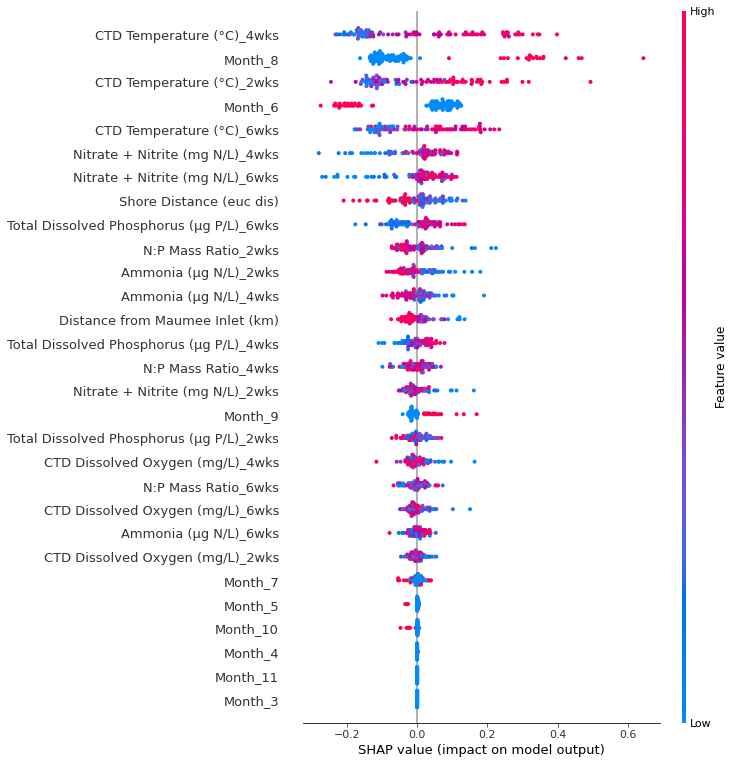

In [331]:
#plot shap values
shap.plots.beeswarm(shap_past_values)

### 1.b.ii. Gradient Boosting with XGBoost

In [168]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr_past = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             max_delta_step=0, max_depth=6, monotone_constraints='()',
             num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
xgbcv_past = RandomizedSearchCV(xgbr_past, params, cv=3, verbose=10, n_jobs=-1)

xgbcv_past.fit(X_past, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   34.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.9s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=None, max_delta_step=0,
                                          max_depth=6, min_child_weight=None,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=None,
                                          nu...
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
   

In [169]:
pd.DataFrame(xgbcv_past.cv_results_).sort_values('rank_test_score').T

,4,1,9,2,5,8,6,3,0,7
mean_fit_time,5.45518,1.68547,2.28164,0.352859,6.71435,2.34032,2.05112,5.67482,5.79899,1.14803
std_fit_time,0.355251,0.237054,0.110956,0.0663394,1.73008,0.0319789,0.390746,0.102275,0.0364504,0.0645954
mean_score_time,0.0220046,0.011926,0.00923038,0.00575455,0.0365226,0.0156291,0.0175481,0.0241039,0.0246191,0.0191437
std_score_time,0.00698452,0.00364268,0.00448031,6.57489e-05,0.0156938,0.00732957,0.00386073,0.0070667,0.0036065,0.0033329
param_n_estimators,50,10,10,10,50,20,20,100,100,10
param_min_child_weight,1,3,3,3,1,0.5,3,1,0.5,1
param_max_depth,50,50,100,None,100,100,10,None,None,10
param_learning_rate,0.1,0.3,0.3,0.1,0.01,0.01,0.01,0.001,0.001,0.001
param_gamma,0.5,0.5,1,0,0.5,0.25,0.5,0.25,1,0
param_colsample_bytree,0.7,0.8,1,0.5,1,0.5,0.8,1,0.7,0.7


In [172]:
xgbcv_past.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=50,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [202]:
xgb_past = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=50,
             min_child_weight=1.0, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

training_scores['XGBoost - Past Features'] = model_train_scores(xgb_past, X_train=X_past)
training_scores['XGBoost - Past Features']

{'MSE': 0.01222784916563989,
 'MAE': 0.08035850416812675,
 'R2': 0.9877721508343601}

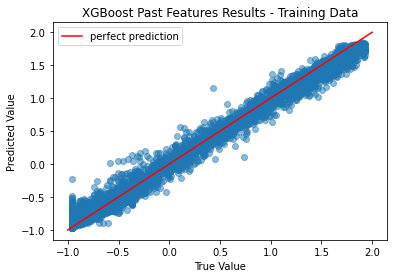

In [180]:
model_train_plot(xgb_past, X_train=X_past, name='XGBoost Past Features')

In [203]:
testing_scores['XGBoost - Past Features'] = model_test_scores(xgb_past, X_train=X_past, X_test=X_past_test)
testing_scores['XGBoost - Past Features']

{'MSE': 0.057666647437506206,
 'MAE': 0.15597187178246116,
 'R2': 0.9410063611162005}

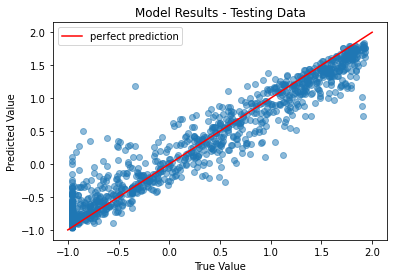

In [183]:
model_test_plot(xgb_past, X_test=X_past_test)

The XGBoost model performs similarly to the random forest, with slightly higher mean average error and the same general tendency to overestimate low values and underestimate high values. Let's also examine the re-transformed results. 

In [304]:
y_pred_xgbpast = xgb_past.predict(X_past_test).reshape(-1,1)
y_pred_xgbpast_ug = logY.inverse_transform(y_pred_xgbpast)

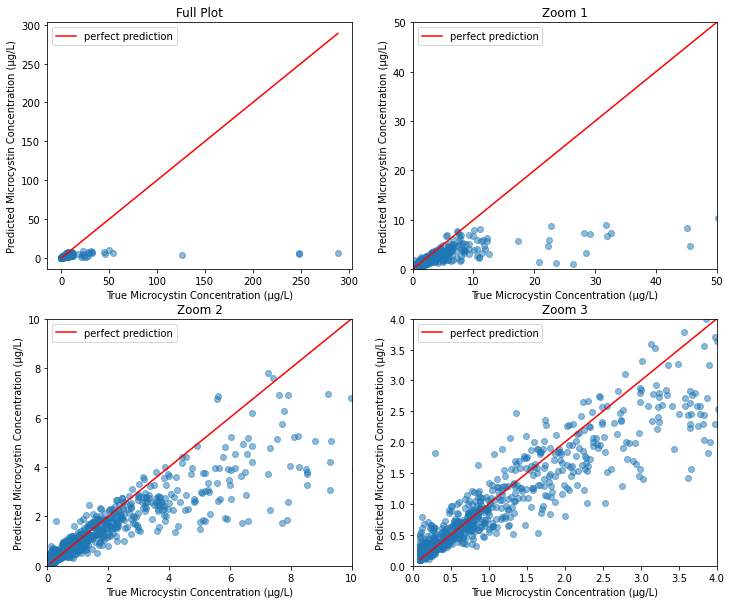

In [305]:
x = np.linspace(min(y_us_test), max(y_us_test), 50)
y = x
fig, ax = plt.subplots(2,2, figsize=(12,10))
for i in range(2):
    for j in range(2):
        ax[i, j].plot(x, y, '-r', label='perfect prediction')
        ax[i, j].scatter(y_test_ug, y_pred_xgbpast_ug, alpha=0.5)
        ax[i,j].legend()
        ax[i, j].set_xlabel('True Microcystin Concentration (µg/L)')
        ax[i, j].set_ylabel('Predicted Microcystin Concentration (µg/L)')
        #ax[i, j].set_title('Random Forest Unscaled Past Features Results - Testing Data')
        
ax[0,0].set_title('Full Plot')
        
ax[0,1].set_xlim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,1].set_title('Zoom 1')

ax[1,0].set_xlim(0,10)
ax[1,0].set_ylim(0,10)
ax[1,0].set_title('Zoom 2')

ax[1,1].set_xlim(0,4)
ax[1,1].set_ylim(0,4)
ax[1,1].set_title('Zoom 3')

plt.show()

In [307]:
mean_absolute_error(y_test_ug, y_pred_xgbpast_ug)

1.2914304990336076

Again we can see that the results are very similar to the random forest performance with very poor prediction for higher microcystin concentrations.

## 1.c. Unscaled Past Features

Since decision trees use single splits to determine outcomes they don't depend on scaling in principal. However, scaling will affect the optimization of a decision tree for a regression problem since varying transformations will affect the magnitude of the residuals. Given the poor performance of scaled features for large microcystin concentrations we will explore unscaled features here.

In [210]:
#load unscaled data
unscaled = pd.read_csv('../data/processed/unscaled.csv', index_col=0)
unscaled.columns

Index(['Site_WE12', 'Site_WE13', 'Site_WE14', 'Site_WE15', 'Site_WE16',
       'Site_WE2', 'Site_WE4', 'Site_WE6', 'Site_WE8', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
       'Particulate Microcystin (µg/L)', 'Total Phosphorus (µg P/L)',
       'Total Dissolved Phosphorus (µg P/L)', 'Ammonia (µg N/L)',
       'Nitrate + Nitrite (mg N/L)', 'N:P Mass Ratio',
       'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
       'CTD Temperature (°C)_1wk', 'CTD Temperature (°C)_2wks',
       'CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
       'CTD Dissolved Oxygen (mg/L)_1wk', 'CTD Dissolved Oxygen (mg/L)_2wks',
       'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
       'Total Dissolved Phosphorus (µg P/L)_1wk',
       'Total Dissolved Phosphorus (µg P/L)_2wks',
       'Total Dissolved Phosphorus (µg P/L)_4wks',
    

In [225]:
#select past features and separate into training and testing split
X_unscaled = unscaled[['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11', 
             'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']].values
y_unscaled = unscaled['Particulate Microcystin (µg/L)'].values

X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_unscaled, y_unscaled, test_size=0.2)

### 1.c.i. Random Forest

In [254]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf_us = RandomForestRegressor()
rf_us_cv = RandomizedSearchCV(rf, params, cv=3, verbose=10, n_jobs=-1)

rf_us_cv.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.6min remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=10)

In [257]:
pd.DataFrame(rf_us_cv.cv_results_).sort_values('rank_test_score').T

,6,7,3,8,1,4,2,9,0,5
mean_fit_time,12.3976,13.7138,5.56465,5.72706,3.78257,11.5477,24.9755,24.2418,8.48344,25.9102
std_fit_time,1.89999,0.902424,0.797663,0.175758,2.07406,0.545858,0.113191,0.445732,0.00807238,1.98209
mean_score_time,0.142028,0.112824,0.169426,0.197394,0.0749538,0.051089,0.68655,0.612733,0.121609,0.55945
std_score_time,0.0938242,0.0402965,0.078506,0.0690389,0.0244092,0.00754179,0.07277,0.0647164,0.00351125,0.0210464
param_n_estimators,100,100,200,200,100,100,1000,1000,200,1000
param_min_samples_split,2,2,2,4,4,10,10,2,4,10
param_min_samples_leaf,1,1,1,1,1,4,1,4,4,4
param_max_features,auto,auto,sqrt,sqrt,sqrt,auto,sqrt,sqrt,sqrt,sqrt
param_max_depth,100,50,10,100,50,10,10,None,100,None
params,"{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 200, 'min_samples_split': 2, ...","{'n_estimators': 200, 'min_samples_split': 4, ...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 100, 'min_samples_split': 10,...","{'n_estimators': 1000, 'min_samples_split': 10...","{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 200, 'min_samples_split': 4, ...","{'n_estimators': 1000, 'min_samples_split': 10..."


In [258]:
#train best random forest regressor on unscaled data
rf_past_us = RandomForestRegressor(n_estimators=100, min_samples_split=2, 
                                     min_samples_leaf=1, max_features='auto')

training_scores['Random Forest - Unscaled Past Features'] = model_train_scores(rf_past_us, X_train=X_us_train, y_train=y_us_train)
training_scores['Random Forest - Unscaled Past Features']

{'MSE': 1.6030327817540089,
 'MAE': 0.2188440775250234,
 'R2': 0.9877933636732357}

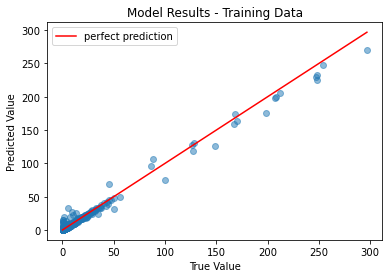

In [259]:
model_train_plot(rf_past_us, X_train=X_us_train, y_train=y_us_train)

In [260]:
testing_scores['Random Forest - Unscaled Past Features'] = model_test_scores(rf_past_us, X_train=X_us_train, y_train=y_us_train, X_test=X_us_test, y_test=y_us_test)
testing_scores['Random Forest - Unscaled Past Features']

{'MSE': 6.585577544152505, 'MAE': 0.5181076591421578, 'R2': 0.9166872706004371}

In [262]:
y_us_pred = rf_past_us.predict(X_us_test)

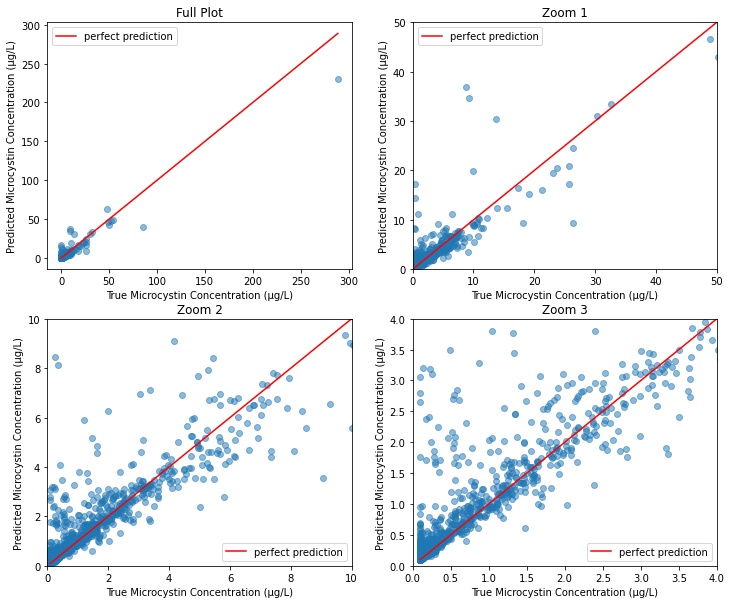

In [263]:
x = np.linspace(min(y_us_test), max(y_us_test), 50)
y = x
fig, ax = plt.subplots(2,2, figsize=(12,10))
for i in range(2):
    for j in range(2):
        ax[i, j].plot(x, y, '-r', label='perfect prediction')
        ax[i, j].scatter(y_us_test, y_us_pred, alpha=0.5)
        ax[i,j].legend()
        ax[i, j].set_xlabel('True Microcystin Concentration (µg/L)')
        ax[i, j].set_ylabel('Predicted Microcystin Concentration (µg/L)')
        #ax[i, j].set_title('Random Forest Unscaled Past Features Results - Testing Data')
        
ax[0,0].set_title('Full Plot')
        
ax[0,1].set_xlim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,1].set_title('Zoom 1')

ax[1,0].set_xlim(0,10)
ax[1,0].set_ylim(0,10)
ax[1,0].set_title('Zoom 2')

ax[1,1].set_xlim(0,4)
ax[1,1].set_ylim(0,4)
ax[1,1].set_title('Zoom 3')

plt.show()

In [342]:
mean_absolute_error(y_us_test, y_us_pred)

0.5181076591421578

Here we can see much more consistent performance across a range of microcystin values and a lower overall absolute error of 0.52 µg/L. Let's examine the feature importances using shap.

In [269]:
data_us = shap.sample(X_us_train, 500)
rf_us_explainer = shap.Explainer(rf_past_us.predict, data_us)

In [270]:
shap_us_values = rf_us_explainer(data_us)

Permutation explainer: 501it [07:47,  1.04it/s]                         


In [271]:
shap_us_values.feature_names = ['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11', 
             'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']

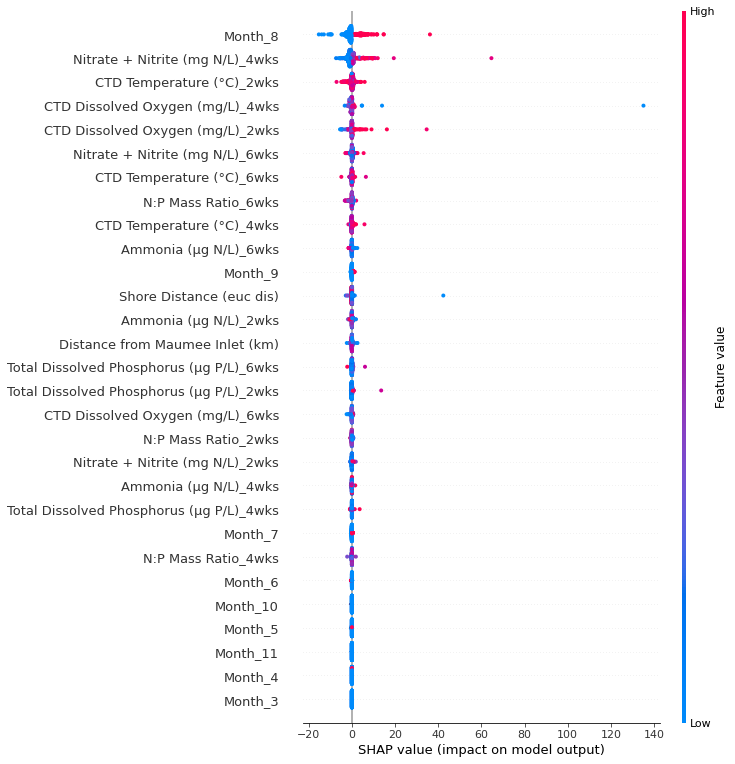

In [272]:
shap.plots.beeswarm(shap_us_values)

### 1.c.ii Gradient Boosting with XGBoost

In [343]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr_us = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             max_delta_step=0, max_depth=6, monotone_constraints='()',
             num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
xgbcv_us = RandomizedSearchCV(xgbr_us, params, cv=3, verbose=10, n_jobs=-1)

xgbcv_us.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.6min remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=None, max_delta_step=0,
                                          max_depth=6, min_child_weight=None,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=None,
                                          nu...
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
   

In [344]:
pd.DataFrame(xgbcv_us.cv_results_).sort_values('rank_test_score').T

,5,0,3,1,4,2,6,8,9,7
mean_fit_time,24.8495,6.09746,13.3622,3.03496,45.6286,1.581,0.760421,8.57407,2.82617,1.35139
std_fit_time,0.883906,0.0809254,0.383515,0.776929,1.77218,0.0624713,0.171028,0.0536152,0.084128,0.118878
mean_score_time,0.0447659,0.0373193,0.304872,0.0338967,0.298156,0.0107905,0.00873001,0.0491707,0.0457257,0.0102164
std_score_time,0.0119882,0.00234808,0.0183964,0.0178873,0.0672824,0.00203663,0.00093777,0.00747165,0.0316069,0.00134647
param_n_estimators,100,20,50,50,100,10,10,50,50,10
param_min_child_weight,0.5,1,3,0.5,5,3,5,1,1,3
param_max_depth,100,50,100,None,100,100,10,100,10,100
param_learning_rate,0.3,0.2,0.3,0.2,0.2,0.2,0.1,0.01,0.001,0.001
param_gamma,0.5,1,0,0.25,0,1,0.5,0.5,0.25,0.25
param_colsample_bytree,0.8,0.9,0.7,0.7,1,0.8,0.7,0.8,0.7,0.9


In [346]:
xgbus_best = xgbcv_us.best_estimator_
training_scores['XGBoost - Unscaled Past Features'] = model_train_scores(xgbus_best, X_train=X_us_train, y_train=y_us_train)
training_scores['XGBoost - Unscaled Past Features']

{'MSE': 0.011311157092912968,
 'MAE': 0.06768175242131923,
 'R2': 0.9999138687725918}

In [347]:
y_usxgb_pred = xgbus_best.predict(X_us_test)

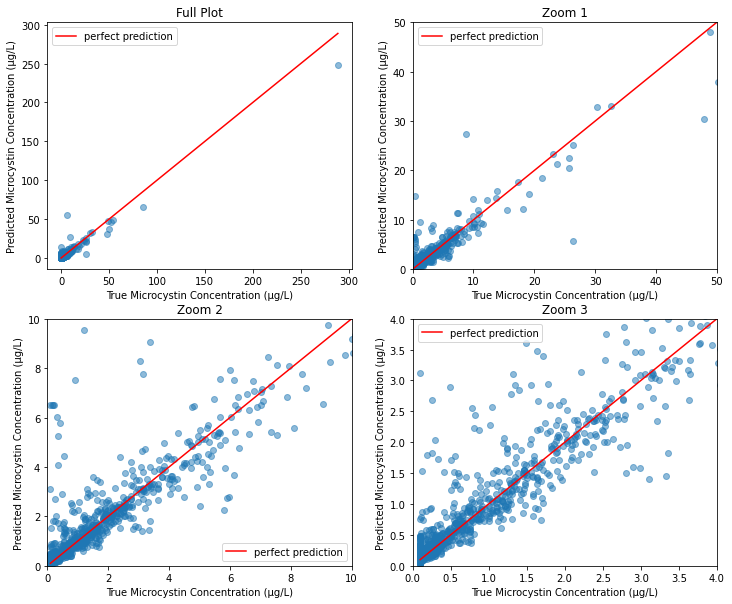

In [348]:
x = np.linspace(min(y_us_test), max(y_us_test), 50)
y = x
fig, ax = plt.subplots(2,2, figsize=(12,10))
for i in range(2):
    for j in range(2):
        ax[i, j].plot(x, y, '-r', label='perfect prediction')
        ax[i, j].scatter(y_us_test, y_usxgb_pred, alpha=0.5)
        ax[i,j].legend()
        ax[i, j].set_xlabel('True Microcystin Concentration (µg/L)')
        ax[i, j].set_ylabel('Predicted Microcystin Concentration (µg/L)')
        #ax[i, j].set_title('Random Forest Unscaled Past Features Results - Testing Data')
        
ax[0,0].set_title('Full Plot')
        
ax[0,1].set_xlim(0,50)
ax[0,1].set_ylim(0,50)
ax[0,1].set_title('Zoom 1')

ax[1,0].set_xlim(0,10)
ax[1,0].set_ylim(0,10)
ax[1,0].set_title('Zoom 2')

ax[1,1].set_xlim(0,4)
ax[1,1].set_ylim(0,4)
ax[1,1].set_title('Zoom 3')

plt.show()

In [401]:
testing_scores['XGBoost - Unscaled Past Features'] = model_test_scores(xgbus_best, X_train=X_us_train, y_train=y_us_train, X_test=X_us_test, y_test=y_us_test)
testing_scores['XGBoost - Unscaled Past Features']

{'MSE': 4.815085362181215, 'MAE': 0.4505288569810022, 'R2': 0.9390853875570264}

For the unscaled data the XGBoost model seems to perform slightly better than Random Forest with a mean absolute error of 0.45 versus 0.52. Let's examine the feature importances for the XGBoost model using shap.

In [351]:
xgbus_explainer = shap.Explainer(xgbus_best.predict, data_us)
shap_xgbus_values = xgbus_explainer(data_us)

Permutation explainer: 501it [02:52,  2.78it/s]                         


In [352]:
shap_xgbus_values.feature_names = ['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11', 
             'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']

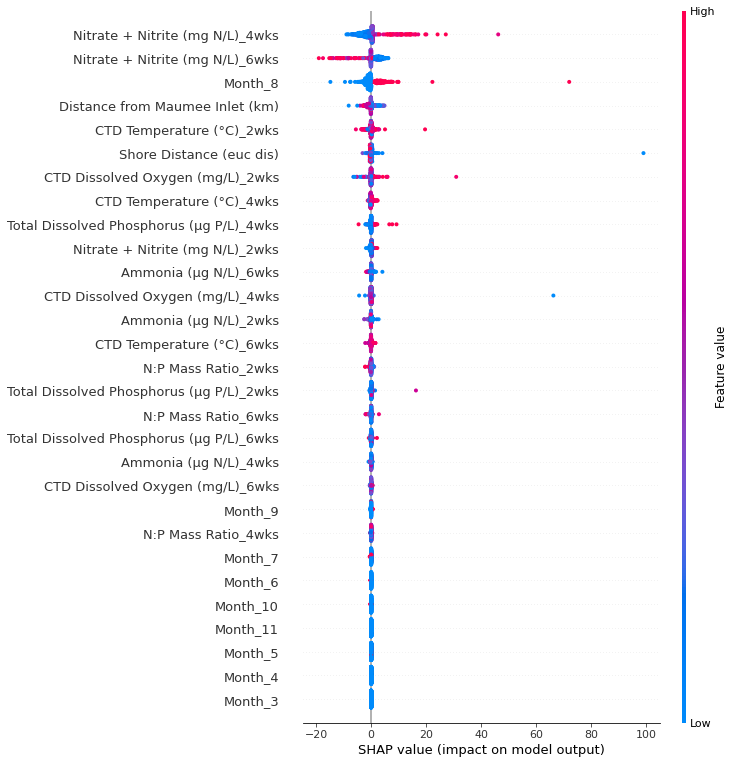

In [353]:
shap.plots.beeswarm(shap_xgbus_values)

## 1.d. Regression Model Evaluation Summary

Note that metrics for unscaled features are not directly comparable with metrics for scaled features.

In [365]:
pd.DataFrame(training_scores).T

,MSE,MAE,R2
OLS - Full Features,0.363127,0.475717,0.636873
Ridge - Full Features,0.363170,0.474750,0.636830
Lasso - Full Features,0.364071,0.475446,0.635929
Random Forest - Full Features,0.004766,0.043756,0.995234
XGBoost - Full Features,0.000023,0.002348,0.999977
Random Forest - Past Features,0.005574,0.046287,0.994426
XGBoost - Past Features,0.012228,0.080359,0.987772
Random Forest - Unscaled Past Features,1.603033,0.218844,0.987793
XGBoost - Unscaled Past Features,0.011311,0.067682,0.999914


In [402]:
pd.DataFrame(testing_scores).T

,MSE,MAE,R2
OLS - Full Features,0.379961,0.483774,0.611295
Ridge - Full Features,0.379829,0.482750,0.611431
Lasso - Full Features,0.380312,0.483153,0.610937
Random Forest - Full Features,0.039541,0.123822,0.959549
XGBoost - Full Features,0.040908,0.105511,0.958151
Random Forest - Past Features,0.045205,0.130863,0.953755
XGBoost - Past Features,0.057667,0.155972,0.941006
Random Forest - Unscaled Past Features,6.585578,0.518108,0.916687
XGBoost - Unscaled Past Features,4.815085,0.450529,0.939085


# 2. Classification

Instead of regression we could take a classification approach by attempting to predict whether microcystin concentrations will be low (i.e. below Ohio EPA drinking limit of 1.6 µg/L), medium (i.e. below Ohio EPA recreational limit of 6µg/L), or high (i.e. above Ohio EPA limit of 20µg/L). We will only use unscaled features and ensemble methods here.

In [362]:
#define function for sorting particulate microcystin concentrations into categories
def pm_cat(pm):
    if pm < 1.6:
        return 0
    elif pm < 6:
        return 1
    elif pm < 20:
        return 2
    else:
        return 3

unscaled['Particulate Microcystin Category'] = unscaled['Particulate Microcystin (µg/L)'].apply(lambda x: pm_cat(x))
unscaled[['Particulate Microcystin Category','Particulate Microcystin (µg/L)']].sample(5)

,Particulate Microcystin Category,Particulate Microcystin (µg/L)
Date,,
2015-07-21,1,5.681429
2014-07-05,0,0.100000
2014-07-09,0,0.166667
2015-07-03,0,0.100000
2013-10-18,0,0.255000


In [400]:
#check out category distributions
unscaled['Particulate Microcystin Category'].value_counts()

0    5603
1    1150
2     339
3      81
Name: Particulate Microcystin Category, dtype: int64

In [363]:
#split into training and testing sets
y_cat = unscaled['Particulate Microcystin Category'].values
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_unscaled, y_cat, test_size=0.2)

## 2.a. Random Forest

In [370]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rfcat = RandomForestClassifier()
rfcat_cv = RandomizedSearchCV(rfcat, params, cv=3, verbose=10, n_jobs=-1)

rfcat_cv.fit(X_cat_train, y_cat_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.0min remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=10)

In [374]:
rfcat_best = rfcat_cv.best_estimator_
rfcat_best.fit(X_cat_train, y_cat_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=10, n_estimators=500)

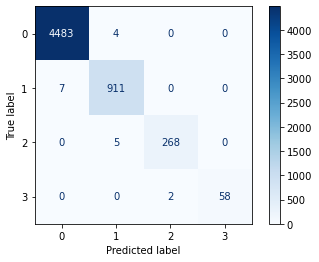

In [384]:
plot_confusion_matrix(rfcat_best, X_cat_train, y_cat_train, cmap='Blues')
plt.show()

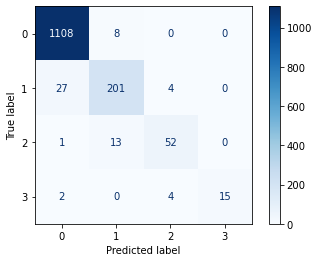

In [385]:
plot_confusion_matrix(rfcat_best, X_cat_test, y_cat_test, cmap='Blues')
plt.show()

For the most part the random forest correctly identifies the class or incorrectly labels a sample as being in a member of an adjacent class, usually the next lowest microcystin level. A total of 3 / 1435 samples were labeled as being more than one class away from the correct label. 

In [387]:
y_rfcat_pred = rfcat_best.predict(X_cat_test)
rfcat_metrics = pd.DataFrame(precision_recall_fscore_support(y_cat_test, y_rfcat_pred), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])


,0,1,2,3
Precision,0.973638,0.905405,0.866667,1.000000
Recall,0.992832,0.866379,0.787879,0.714286
Fscore,0.983141,0.885463,0.825397,0.833333
Support,1116.000000,232.000000,66.000000,21.000000


In [388]:
rfcat_explainer = shap.Explainer(rfcat_best.predict, data_us)
shap_rfcat_values = rfcat_explainer(data_us)

Permutation explainer: 501it [46:54,  5.65s/it]                             


In [389]:
shap_rfcat_values.feature_names = ['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11', 
             'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']

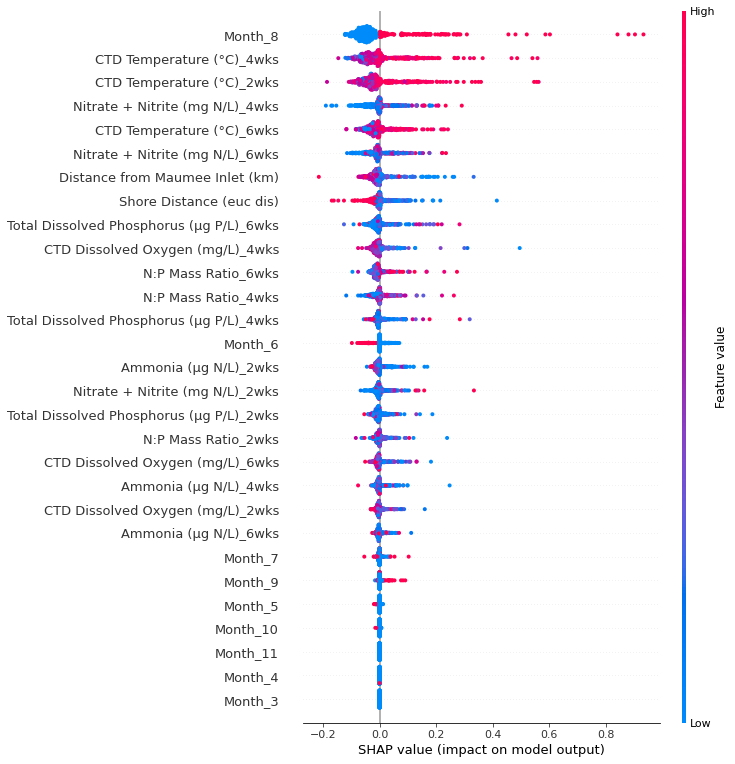

In [390]:
shap.plots.beeswarm(shap_rfcat_values)

## 2.b. XGBoost Classifier

In [392]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'objective': ['binary:logistic', 'multi:softmax'],
    'num_class': [4]
}

xgbcat = xgb.XGBClassifier()
xgbcat_cv = RandomizedSearchCV(xgbcat, params, cv=3, verbose=10, n_jobs=-1)
xgbcat_cv.fit(X_cat_train, y_cat_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   52.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.9s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [393]:
xgbcat_best = xgbcat_cv.best_estimator_
xgbcat_best.fit(X_cat_train, y_cat_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

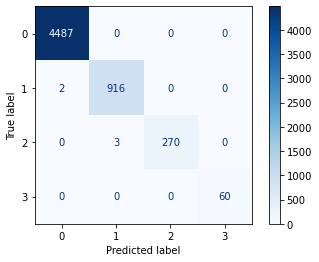

In [394]:
plot_confusion_matrix(xgbcat_best, X_cat_train, y_cat_train, cmap='Blues')
plt.show()

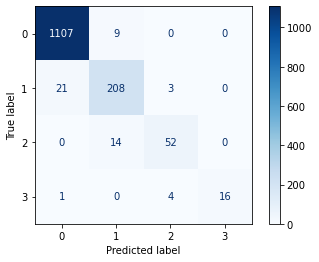

In [395]:
plot_confusion_matrix(xgbcat_best, X_cat_test, y_cat_test, cmap='Blues')
plt.show()

In [396]:
y_xgbcat_pred = xgbcat_best.predict(X_cat_test)
xgbcat_metrics = pd.DataFrame(precision_recall_fscore_support(y_cat_test, y_xgbcat_pred), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1,2,3
Precision,0.980514,0.900433,0.881356,1.000000
Recall,0.991935,0.896552,0.787879,0.761905
Fscore,0.986192,0.898488,0.832000,0.864865
Support,1116.000000,232.000000,66.000000,21.000000


XGBoost seems to perform marginally better than random forest on all metrics for classification.

In [397]:
xgbcat_explainer = shap.Explainer(xgbcat_best.predict, data_us)
shap_xgbcat_values = xgbcat_explainer(data_us)

Permutation explainer: 501it [12:52,  1.56s/it]                         


In [398]:
shap_xgbcat_values.feature_names = ['Month_3', 'Month_4','Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10','Month_11', 
             'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']

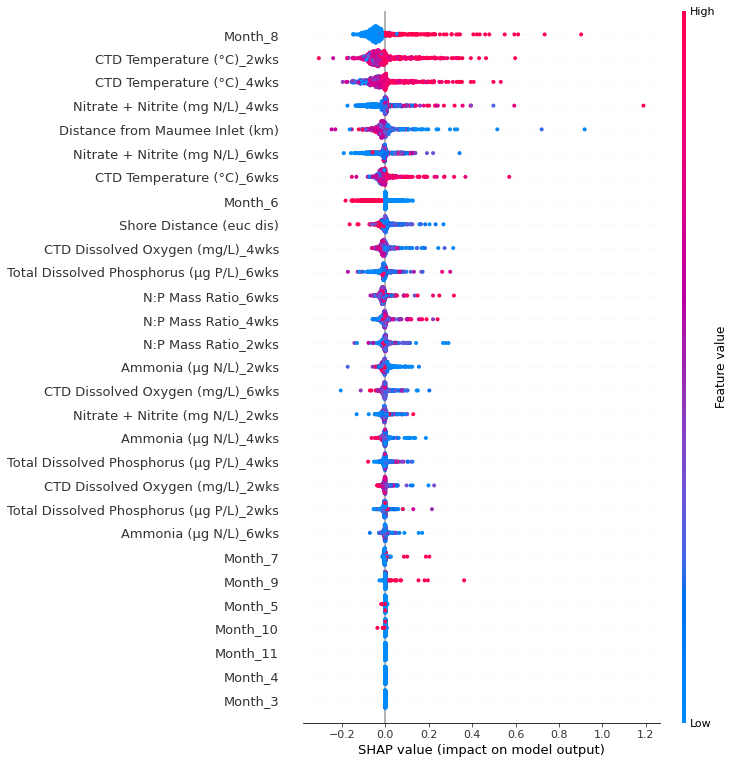

In [399]:
shap.plots.beeswarm(shap_xgbcat_values)